[main 0491eb9] Added barcode py
 1 file changed, 26 insertions(+)
 create mode 100644 utils/barcode_utils.py
Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 631 bytes | 631.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/waleedrazakhan92/pdf_parsing.git
   b91cae5..0491eb9  main -> main


In [1]:
!git clone https://github.com/waleedrazakhan92/pdf_parsing.git

Cloning into 'pdf_parsing'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 1), reused 10 (delta 1), pack-reused 0
Receiving objects: 100% (15/15), 37.48 KiB | 18.74 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [20]:
%cd '/content/pdf_parsing/'

/content/pdf_parsing


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp -r '/content/drive/MyDrive/shared_with_faizan/micheal_solomon/documents/' '/content/'
# !cp -r '/content/drive/MyDrive/shared_with_faizan/micheal_solomon/junk/page_tables/' '/content/'

In [11]:
print('-------------------------')
!sudo apt clean
!sudo apt autoclean
!sudo apt update
print('-------------------------')
!apt-get install tesseract-ocr
print('-------------------------')
!apt-get install libtesseract-dev
print('-------------------------')
!pip install pytesseract
print('-------------------------')
# !apt-get install poppler-utils
!sudo apt-get install --fix-missing poppler-utils
print('-------------------------')
!pip install pdf2image
print('-------------------------')
!pip install deskew
print('-------------------------')
!pip install PyPDF2
print('-------------------------')
!pip install zxing-cpp
print('-------------------------')


-------------------------
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
20 packages can be upgraded. Run 'apt list --

# Pipeline

In [6]:
%cd '/content/pdf_parsing/'

/content/pdf_parsing


In [7]:

import matplotlib.pyplot as plt
import numpy as np

def cv2_imshow_rgb(img,resize=None, figsize=(15,15)):
    if resize!=None:
        img=cv2.resize(img,resize)

        #     cv2_imshow(cv2.cvtColor(np.uint8(img),cv2.COLOR_RGB2BGR))

    plt.figure(figsize=figsize)
    plt.imshow(np.uint8(img))


def display_multi(*images,resize=None, figsize=(15,15),bgr=False,axis=1):
    if resize!=None:
        res = np.array(cv2.resize(images[0],resize))
    else:
        res = np.array(images[0])

    for i in range(1,len(images)):

        if resize!=None:
            res_img = np.array(cv2.resize(images[i],resize))
        else:
            res_img = np.array(images[i])

        res = np.concatenate((res, res_img), axis=axis)

    if bgr==True:
        res = cv2.cvtColor(res,cv2.COLOR_BGR2RGB)

    return cv2_imshow_rgb(res,resize=None, figsize=figsize)

In [13]:
import argparse
from pdf2image import convert_from_path
import pytesseract
from PIL import Image
import os
import shutil
import re
import cv2
import numpy as np
import skimage
# from skimage.transform import rotate
from PyPDF2 import PdfWriter, PdfReader

import math
from tqdm import tqdm
from glob import glob

from utils.load_and_preprocess_utils import preprocess_image
from utils.table_utils import extract_all_tables,cropped_tables_to_data
from utils.non_table_utils import img_to_all_data_dicts,data_dict_to_data
from utils.non_table_utils import erode_and_find_contours
from utils.formatting_utils import *
from utils.notice_and_case_types import *
from utils.common_functions import *

def process_and_save(all_pages,junk_folder=None,display_info=False,st_i=None,end_i=None,save_jpegs=False):
    if save_jpegs==True:
        assert junk_folder!=None

    ## Settings
    ## pre processing options
    op_dpi = (300,300)
    op_deskew = True
    op_img_thresh = False   ## True makes I to 1 so keep it false
    op_borders = (False,10,(0,0,0))

    ## thresholding and morphology
    # ['try_all_threshold','threshold_otsu','threshold_yen','threshold_isodata','threshold_li','threshold_local','threshold_minimum','threshold_mean', 'threshold_niblack','threshold_sauvola','threshold_triangle','apply_hysteresis_threshold','threshold_multiotsu']
    thresh_filter = None#skimage.filters.threshold_otsu
    op_morph = None #apply_morph(img,morph_operation=cv2.MORPH_CLOSE,kernel=(3,3),iterations=1)


    all_final_names = []
    all_final_appends = []
    ## Init dictionaries
    all_tables_info = {}
    all_doc_info = {}

    info_dict_old = {}
    info_dict_old['name'] = None
    info_dict_old['case_type'] = None
    info_dict_old['doc_type'] = None

    info_dict = {}
    info_dict['name'] = None
    info_dict['case_type'] = None
    info_dict['doc_type'] = None

    corrupts = []
    if st_i==None:
        st_i = 0
    if end_i==None:
        end_i = len(all_pages)

    for i in tqdm(range(st_i,end_i)):
        # try:
        pg_num = i+1

        ## Init dictionaries
        all_tables_info = {}
        all_doc_info = {}
        info_dict = {}

        sp_name = 'page_'+str(pg_num)
        img = cv2.cvtColor(np.array(all_pages[i]),cv2.COLOR_RGB2GRAY)

        try:
            img = check_orientation_tesseract(np.array(img))
        except:
            pass

        img = preprocess_image(img,deskew=op_deskew,img_thresh=op_img_thresh,\
                                add_border=op_borders[0],border_width=op_borders[1],border_color=op_borders[2],img_type='gray')

        img_h,img_w = img.shape

        init_type = detect_tables_vs_nontables(img,display_info=False)
        if display_info==True:
            print('')
            print('Table/Not: ',init_type)

        ## ------------------------------------------
        ### Detection using tables
        ## ------------------------------------------
        ## resize image to make sure the capital letters are 30pixels in height
        if init_type=='Tables':
            table_resize = 2
            fake_table = True
            all_tables,table_coordinates = extract_all_tables(img.copy(),sp_name,path_cropped="page_tables/",filter_tables=True,
                                                            save_crops=False,save_overlay=False,fake_table=fake_table,fake_line=False,
                                                            resize=table_resize)


            narrow_cell = True
            all_tables_info = cropped_tables_to_data(all_tables,table_coordinates,fake_table,notice_types_tables,all_case_types_tables,thresh_filter=thresh_filter,
                                        op_borders=10,display_info=display_info,op_morph=op_morph,narrow_cell=narrow_cell)

            all_tables_info['init_type'] = init_type
            # if all_tables_info['notice_type'] in notice_types_tables.keys():
            info_dict = final_naming_tables(all_tables_info)

        else:
            ## ------------------------------------------
            ### Detection without tables
            ## ------------------------------------------
            all_data_dicts = img_to_all_data_dicts(img)
            all_doc_info = data_dict_to_data(all_data_dicts,all_doc_tags,all_doc_tags_partial,all_case_types_tables)
            all_doc_info['init_type'] = init_type
            info_dict = final_naming_nontables(all_doc_info)

            if display_info==True:
                print('----------------------')
                print('All data dicts')
                print('----------------------')
                for d_d in all_data_dicts:
                    print(d_d[0])

        append_page = decide_page(info_dict,info_dict_old,notice_types_tables,all_doc_tags)
        ## update old dict
        info_dict_old = info_dict

        ## Extract important info
        final_name = info_dict['name']
        case_type = info_dict['case_type']
        doc_type = info_dict['doc_type']

        ## Correct final formats
        final_name = format_name(final_name)
        case_type = correct_final_case_type(case_type)
        doc_type = correct_final_doc_type(doc_type)

        ## If doc_type==ASC read from barcode
        if doc_type=='ASC':
            try:
                bcode_417 = read_bcode_from_img(img)
                bcode_name = get_name_from_bcode(bcode_417)
                # separator=' '
                # bcode_name = str(separator.join(bcode_name))
                final_name = bcode_name
            except:
                pass

        ##############################################
        ## saving images

        save_name_full = None
        save_name_full = str(pg_num)+'_'+str(final_name)+'_'+str(case_type)+'_'+str(doc_type)+".jpg"
        if save_jpegs==True:
            save_name_full = os.path.join(junk_folder,save_name_full)
            cv2.imwrite(save_name_full,img,[cv2.IMWRITE_JPEG_QUALITY, 10])

        all_final_names.append(save_name_full)
        all_final_appends.append(append_page)

        if display_info==True:
            print(' ')
            print(save_name_full)
            print('Page:',append_page)
            # print(all_tables_info)
            print('-----------Tables-------------------')
            for k in all_tables_info:
                print(k,'==',all_tables_info[k])

            print('-----------No Tables-------------------')
            for k in all_doc_info:
                print(k,'==',all_doc_info[k])

            print('-----------Info Dict-------------------')
            for k in info_dict:
                print(k,'==',info_dict[k])

            display_multi(img)

        # except:
        #     print('')
        #     print('Corrupt:',pdf_name,pg_num)
        #     corrupts.append((pdf_name,pg_num))

    return all_final_names,all_final_appends,corrupts

In [14]:
from utils.common_functions import delete_characters,find_element_index
def format_name(in_name):

    # print('')
    # print('#############################')
    # print(in_name)
    # print('#############################')

    if in_name==None:
        return in_name

    in_name_clean = delete_characters(in_name,[',','.'])
    in_name_clean = in_name_clean.split(' ')

    in_name = in_name.split(' ')
    indices = find_element_index(in_name,',')

    if indices==0 and len(in_name_clean)>1:
        f_name = in_name_clean[0]+', '+in_name_clean[1]
    elif len(in_name_clean)>1 and len(in_name_clean)!=4 and indices==[]:
        f_name = in_name_clean[-1]+', '+in_name_clean[0]
    elif len(in_name_clean)>1 and len(in_name_clean)==4 and indices==[]:
        f_name = in_name_clean[-2]+' '+in_name_clean[-1]+', '+in_name_clean[0]
    else:
        f_name = in_name_clean[0]


    # print('#############################')
    # print(f_name)
    # print('#############################')
    return f_name

In [23]:
### %%writefile /content/pdf_parsing/utils/barcode_utils.py
import zxingcpp
def read_bcode_from_img(img):
    bcode_results = zxingcpp.read_barcodes(img)
    for result in bcode_results:
        if result.format==zxingcpp.BarcodeFormat.PDF417:
            return result

    return None

def get_name_from_bcode(bcode_417):
    name_keys = ['g','h','i']
    bcode_text = bcode_417.text.split('name')[-1].split(',')

    bcode_name = []
    for i in range(0,len(bcode_text)):
        if bcode_text[i][0]==name_keys[0] and bcode_text[i+1][0]==name_keys[1] and bcode_text[i+2][0]==name_keys[2]:
            bcode_name.append(bcode_text[i][1:])
            bcode_name.append(bcode_text[i+1][1:])
            bcode_name.append(bcode_text[i+2][1:])
        elif bcode_text[i][0]==name_keys[0] and bcode_text[i+1][0]==name_keys[1]:
            bcode_name.append(bcode_text[i][1:])
            bcode_name.append(bcode_text[i+1][1:])
        elif bcode_text[i][0]==name_keys[0]:
            bcode_name.append(bcode_text[i][1:])

    return bcode_name

Writing /content/pdf_parsing/utils/barcode_utils.py


In [17]:
# all_documents = glob("/content/documents/forms/*")
all_documents = glob("/content/documents/AI Receipts Project/*")

print('Total Documents:',len(all_documents))
print(all_documents)

pdf_path = '/content/documents/AI Receipts Project/A-2.pdf' #all_documents[1]
pdf_name,_ = os.path.splitext(pdf_path.split('/')[-1])
print(pdf_path,pdf_name)
print('Size(Mb):',round(os.path.getsize(pdf_path)/1024/1024))

## convert pdf to images
all_pages = convert_from_path(pdf_path)
print('Total Pages:',len(all_pages))


Total Documents: 40
['/content/documents/AI Receipts Project/V-2.pdf', '/content/documents/AI Receipts Project/B-2.pdf', '/content/documents/AI Receipts Project/R-1.pdf', '/content/documents/AI Receipts Project/P-1.pdf', '/content/documents/AI Receipts Project/A-2.pdf', '/content/documents/AI Receipts Project/H-1.pdf', '/content/documents/AI Receipts Project/N-1.pdf', '/content/documents/AI Receipts Project/V-1.pdf', '/content/documents/AI Receipts Project/Q-1.pdf', '/content/documents/AI Receipts Project/L-2.pdf', '/content/documents/AI Receipts Project/C-1.pdf', '/content/documents/AI Receipts Project/M-2.pdf', '/content/documents/AI Receipts Project/W-1.pdf', '/content/documents/AI Receipts Project/K-1.pdf', '/content/documents/AI Receipts Project/I-1.pdf', '/content/documents/AI Receipts Project/Z-1.pdf', '/content/documents/AI Receipts Project/E-2.pdf', '/content/documents/AI Receipts Project/C-2.pdf', '/content/documents/AI Receipts Project/B-1.pdf', '/content/documents/AI Receip

In [18]:
junk_folder = os.path.join('/content/',pdf_name+'_junk/')
!rm -r {junk_folder}

if not os.path.isdir(junk_folder):
    os.mkdir(junk_folder)

st_i = 5
num_forms = 3
end_i = st_i+num_forms
end_i = len(all_pages)#st_i+num_forms #min(st_i+num_forms,len(selected_pages))

# all_pages = [Image.open('/content/K1-3.png')]
selected_pages = all_pages

display_info=False
save_jpegs = True
all_final_names,all_final_appends,corrupts = process_and_save(all_pages,junk_folder,display_info=display_info,st_i=st_i,end_i=end_i,save_jpegs=save_jpegs)
# display_multi(all_pages[st_i])


rm: cannot remove '/content/A-2_junk/': No such file or directory


100%|██████████| 34/34 [04:48<00:00,  8.49s/it]


In [ ]:
path_write_pdf = os.path.join('/content/',pdf_name+'_pdfs/')
path_write_images = os.path.join('/content/',pdf_name+'_images/')

!rm -r {path_write_pdf}
!rm -r {path_write_images}

if not os.path.isdir(path_write_pdf):
    os.mkdir(path_write_pdf)


if not os.path.isdir(path_write_images):
    os.mkdir(path_write_images)

all_files_pagewise = make_pagewise_list(all_final_names,all_final_appends)

break_pdf_to_files(pdf_path,path_write_pdf,all_files_pagewise,compress_pdf=True,pg_num=True)

selected_pages = selected_pages[st_i:end_i]
break_pdf_to_images(selected_pages,path_write_images,all_files_pagewise,jpeg_quality=10,pg_num=True)

zip_name = os.path.join('/content/',pdf_name+'.zip')
!zip -r {zip_name} {path_write_images}


In [ ]:
# !zip -r '/content/all_pdf_tables.zip' '/content/all_pdf_tables/'
# !cp '/content/all_pdf_tables.zip' '/content/drive/MyDrive/immediate/'

In [ ]:
# print(corrupts)

# [('A-2', 1), ('D-1', 3), ('D-1', 6), ('H-1', 31), ('P-2', 44), ('R-1', 39), ('V-1', 15)]

In [ ]:
# B-2 3 what form is this
# K-1 3  what form is this
# M-2 62,69 what form is this
# P-1 30 ma masla ha. pichlay waloon k saat append hua wa tha
# P-2 20 what form is this
# R-1 24 what form is this
# S-1 19 "Biometric Notification"
# V-1 3  "Biometric Notification"


In [ ]:
# junk 5
# C-2 45-46-47-48 should have 4 pages
# S-1 completely bad

In [ ]:
## if name==None, case=485, doc_type=Interview   THEN page=2
## if prevous doc_type=RFE and current name,doc_type,case_type=None THEN page=2
## if previous=None,None,None and current=None,None,None then page=3

In [ ]:
## Tables vs non tables
# B2-3
# J2-7
# K1-3
# M1-19
# M2-40
# P1-28
# P2-20
# R1-24
# V2-16


# F2-18
# S1-19

In [ ]:
sad

# Loop

In [ ]:
# all_documents = glob("/content/documents/forms/*")
all_documents = glob("/content/documents/AI Receipts Project/*")
all_documents.sort()
print('Total Documents:',len(all_documents))
print(all_documents)


In [ ]:

## Settings

## pre processing options
op_dpi = (300,300)
op_deskew = True
op_img_thresh = False   ## True makes I to 1 so keep it false
op_borders = (False,10,(0,0,0))

## thresholding and morphology
# ['try_all_threshold','threshold_otsu','threshold_yen','threshold_isodata','threshold_li','threshold_local','threshold_minimum','threshold_mean', 'threshold_niblack','threshold_sauvola','threshold_triangle','apply_hysteresis_threshold','threshold_multiotsu']
thresh_filter = None#skimage.filters.threshold_otsu
op_morph = None #apply_morph(img,morph_operation=cv2.MORPH_CLOSE,kernel=(3,3),iterations=1)


In [ ]:
# path_write_pdf = os.path.join('/content/',pdf_name+'_pdfs/')
# path_write_images = os.path.join('/content/',pdf_name+'_images/')

# !rm -r {path_write_pdf}
# !rm -r {path_write_images}

# if not os.path.isdir(path_write_pdf):
#     os.mkdir(path_write_pdf)


# if not os.path.isdir(path_write_images):
#     os.mkdir(path_write_images)

In [ ]:
display_info=False
save_jpegs = False
save_images = True
save_zips = True

!rm -r '/content/processed_pdfs/'
path_write_all = '/content/drive/MyDrive/immediate/processed_pdfs/'
if not os.path.isdir(path_write_all):
    os.mkdir(path_write_all)

path_write_pdfs = os.path.join(path_write_all,'pdfs/')
if not os.path.isdir(path_write_pdfs):
    os.mkdir(path_write_pdfs)

if save_jpegs==True:
    path_write_junk = os.path.join(path_write_all,'junk/')
    if not os.path.isdir(path_write_junk):
        os.mkdir(path_write_junk)

if save_images==True:
    path_write_images = os.path.join(path_write_all,'images/')
    if not os.path.isdir(path_write_images):
        os.mkdir(path_write_images)

if save_zips==True:
    path_write_zips = os.path.join(path_write_all,'zips/')
    if not os.path.isdir(path_write_zips):
        os.mkdir(path_write_zips)


st_i = None#0
num_forms = None# 1
end_i = None#5#st_i+num_forms

all_corrupts = []
for doc_index in tqdm(range(0,len(all_documents[:]))):

    pdf_path = all_documents[doc_index]
    pdf_name,_ = os.path.splitext(pdf_path.split('/')[-1])
    print(pdf_path,pdf_name)
    print('Size(Mb):',round(os.path.getsize(pdf_path)/1024/1024))

    # if os.path.isfile(os.path.join(save_zip_path,pdf_name+'.zip')):
    #     continue

    ## convert pdf to images
    all_pages = convert_from_path(pdf_path)
    print('Total Pages:',len(all_pages))

    if save_jpegs==True:
        junk_folder = os.path.join(path_write_images,pdf_name+'_junk/')
        if not os.path.isdir(junk_folder):
            os.mkdir(junk_folder)
    else:
        junk_folder = None

    pdf_folder = os.path.join(path_write_images,pdf_name+'_pdfs/')
    if not os.path.isdir(pdf_folder):
        os.mkdir(pdf_folder)

    if save_images==True:
        images_folder = os.path.join(path_write_images,pdf_name+'_images/')
        if not os.path.isdir(images_folder):
            os.mkdir(images_folder)

    all_final_names,all_final_appends,corrupts = process_and_save(all_pages,junk_folder,display_info=display_info,st_i=st_i,end_i=end_i,save_jpegs=save_jpegs)
    all_corrupts.append(all_corrupts)

    all_files_pagewise = make_pagewise_list(all_final_names,all_final_appends)
    break_pdf_to_files(pdf_path,pdf_folder,all_files_pagewise,compress_pdf=True)

    if save_images==True:
        selected_pages = all_pages[st_i:end_i]
        break_pdf_to_images(selected_pages,images_folder,all_files_pagewise,jpeg_quality=10)

    if save_zips==True:
        zip_name = os.path.join(path_write_zips,pdf_name+'.zip')
        !zip -r {zip_name} {images_folder}


In [ ]:
print(all_corrupts)

In [ ]:
# !mkdir '/content/drive/MyDrive/micheal_junk_5/'

In [ ]:

# print(corrupts)

# [('A-2', 1), ('D-1', 3), ('D-1', 6), ('H-1', 31), ('P-2', 44), ('R-1', 39), ('V-1', 15)]

In [ ]:
# !mkdir '/content/drive/MyDrive/micheal_junk_2/'

In [ ]:
# # all_documents = glob("/content/documents/forms/*")
# all_documents = glob("/content/documents/AI Receipts Project/*")
# all_documents.sort()
# print('Total Documents:',len(all_documents))
# print(all_documents)

# !rm -r '/content/all_pdf_images/'
# display_info=False
# save_jpegs = True
# st_i = None
# num_forms = 1
# end_i = None#st_i+num_forms

# path_write_images = '/content/all_pdf_images/'
# if not os.path.isdir(path_write_images):
#     os.mkdir(path_write_images)

# all_corrupts = []
# for doc_index in tqdm(range(0,len(all_documents))):

#     pdf_path = all_documents[doc_index]
#     pdf_name,_ = os.path.splitext(pdf_path.split('/')[-1])
#     if not os.path.isdir(os.path.join(path_write_images,pdf_name)):
#         os.mkdir(os.path.join(path_write_images,pdf_name))

#     print(pdf_path,pdf_name)
#     print('Size(Mb):',round(os.path.getsize(pdf_path)/1024/1024))

#     ## convert pdf to images
#     all_pages = convert_from_path(pdf_path)
#     print('Total Pages:',len(all_pages))


#     for j in range(0,len(all_pages)):
#         save_img_name = os.path.join(path_write_images,pdf_name,'page_'+str(j+1)+'.jpg')
#         cv2.imwrite(save_img_name,np.array(all_pages[j]),[cv2.IMWRITE_JPEG_QUALITY, 10])

#Notes

In [ ]:
## Notes
# deskew
# dpi 300 best
# border/no-border

# Test
# test thresholding
# load_system_dawg and load_freq_dawg to false
# The text detection for tables is image resolution*2 and for normal document is resolution*1. remember 30pix is ideal case


In [ ]:
# Ideas
# Find just the table or its entries and read the values directly for example the cell with petitioner should have a have directly below it
# Delete the unnecessery columns
# Read the document only optill a certain point
# Put black color on the unnecessery areas
# .tiff format for printing


In [ ]:
## explanation for psm types
# yaheen sa manay --psm 4 for tables dakha tha
# https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/


## detecting tables from images
# https://betterprogramming.pub/extracting-tables-from-images-in-python-made-easy-ier-3be959555f6f

In [ ]:
## for table detection
'''
Note: Depending on the image, you may have to modify the kernel size. For instance to capture longer horizontal lines,
it may be necessary to increase the horizontal kernel from (40, 1) to say (80, 1). If you wanted to detect thicker horizontal lines,
then you could increase the width of the kernel to say (80, 2). In addition, you could increase the number of iterations when performing cv2.morphologyEx().
Similarly, you could modify the vertical kernels to detect more or less vertical lines.
There is a trade-off when increasing or decreasing the kernel size as you may capture more or less of the lines. Again, it all varies depending on the input image
'''

In [ ]:
## For case type detection
'''
make sure if all case types are I-something. If thats the case the just hadcode I and then extract the rest of it.
some case dont have a "-" in I-123  see how to tackle that?
'''

In [ ]:
## utilize str.strip() and str.replace()

# Barcode

In [ ]:
!pip install pdf417decoder
!pip3 install zxing
!pip install zxing-cpp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.1/680.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.6/899.6 kB 7.3 MB/s eta 0:00:00


In [ ]:
from PIL import Image as PIL
from pdf417decoder import PDF417Decoder



In [ ]:
from collections import namedtuple

import numpy
import numpy as np
import cv2

# Based on https://github.com/pyxploiter/Barcode-Detection-and-Decoding

Region = namedtuple('Region', 'image rect box percent area shape box_percent')

def detect_regions_multipage(images):
    results = []
    for image in images:
        res = detect_regions(image)
        results.append(res)
    return results


def detect_regions(pil_image, top_k=5):
    original_image = numpy.array(pil_image)
    image = numpy.array(pil_image)

    # resize image
    image = cv2.resize(image, None, fx=0.7, fy=0.7, interpolation=cv2.INTER_CUBIC)

    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # calculate x & y gradient
    gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)

    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    # blur the image
    blurred = cv2.blur(gradient, (3, 3))

    # threshold the image
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

    # construct a closing kernel and apply it to the thresholded image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (86, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # perform a series of erosions and dilations
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)

    # find the contours in the thresholded image, then sort the contours
    # by their area, keeping only the largest one
    cnts, hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    c_topk = sorted(cnts, key=cv2.contourArea, reverse=True)[:top_k]

    crops = []
    for idx, c in enumerate(c_topk):
        # compute the rotated bounding box of the largest contour
        rect = cv2.minAreaRect(c)
        box = np.int0(cv2.boxPoints(rect))

        image_crop, image_rot = crop_minAreaRect(image, rect)
        image_crop_thresh, _ = crop_minAreaRect(thresh, rect)

        area = cv2.contourArea(c)
        black_pixels = np.count_nonzero(image_crop_thresh)
        percent_dark = black_pixels / image_crop.size

        box = np.array(box, dtype=np.float64)
        box[:, 0] = box[:, 0] / image.shape[0]
        box[:, 1] = box[:, 1] / image.shape[1]
        crops.append(Region(image_crop, rect, box, percent_dark, area, image.shape, box))
    # logger.info(f"black pixels: {percent_dark}")

    crops_sorted = sorted(crops, key=lambda reg: (reg.rect[0][1], reg.rect[0][0]), reverse=False)

    for idx, region in enumerate(crops_sorted):
        rect = region.rect
        box = np.int0(cv2.boxPoints(region.rect))
        # draw a bounding box arounded the detected barcode and display the image
        cv2.drawContours(image, [box], -1, (0, 255, 0), 3)

        percent = "{:.3f}".format(percent_dark)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image, str(idx), (int(rect[0][0]), int(rect[0][1])), font, 4, (0, 255, 0), 2, cv2.LINE_AA)

    image = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
    return crops_sorted

def crop_minAreaRect(img, rect):
    # get the parameter of the small rectangle
    center = rect[0]
    size = rect[1]
    angle = rect[2]

    if size[0] < size[1]:
        angle = angle - 90
        size = [size[1], size[0]]


    center, size = tuple(map(int, center)), tuple(map(int, size))

    w = 30
    h = 20
    size = (size[0] + w, size[1] + h)
    # get row and col num in img
    height, width = img.shape[0], img.shape[1]
    # print("width: {}, height: {}".format(width, height))

    M = cv2.getRotationMatrix2D(center, angle, 1)
    img_rot = cv2.warpAffine(img, M, (width, height))

    img_crop = cv2.getRectSubPix(img_rot, size, center)

    return img_crop, img_rot

In [ ]:
import zxing
import zxingcpp
import PIL
reader = zxing.BarCodeReader()

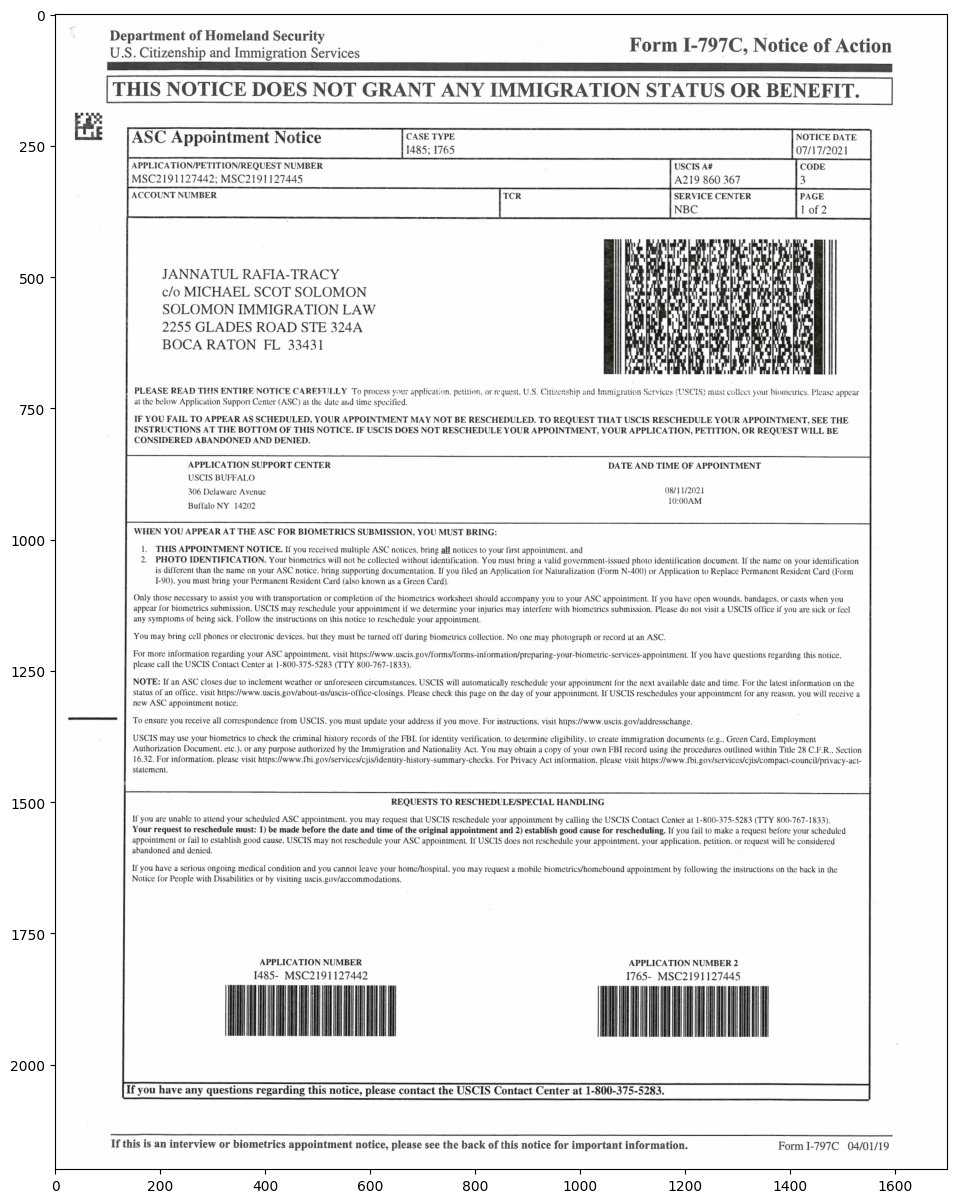

In [ ]:
img = cv2.imread('/content/documents/131_raw/page_71.png')
img_regions = detect_regions(img)
len(img_regions)
display_multi(img)



In [ ]:
def filter_barcodes(img_regions):
    filt_bcodes = []
    for i in range(0,len(img_regions)):
        # display_multi(img_regions[i].image,figsize=(3,3))
        b_h,b_w = np.shape(img_regions[i].image)[:2]
        if b_h>150 and b_w<500:
            filt_bcodes.append(img_regions[i])

    return filt_bcodes

def read_bcode_from_img(img):
    bcode_results = zxingcpp.read_barcodes(img)
    for result in bcode_results:
        if result.format==zxingcpp.BarcodeFormat.PDF417:
            return result

    return None

def get_name_from_bcode(bcode_417):
    name_keys = ['g','h','i']
    bcode_text = bcode_417.text.split('name')[-1].split(',')

    bcode_name = []
    for i in range(0,len(bcode_text)):
        if bcode_text[i][0]==name_keys[0] and bcode_text[i+1][0]==name_keys[1] and bcode_text[i+2][0]==name_keys[2]:
            bcode_name.append(bcode_text[i][1:])
            bcode_name.append(bcode_text[i+1][1:])
            bcode_name.append(bcode_text[i+2][1:])
        elif bcode_text[i][0]==name_keys[0] and bcode_text[i+1][0]==name_keys[1]:
            bcode_name.append(bcode_text[i][1:])
            bcode_name.append(bcode_text[i+1][1:])
        elif bcode_text[i][0]==name_keys[0]:
            bcode_name.append(bcode_text[i][1:])

    return bcode_name

In [ ]:
filt_bcodes = filter_barcodes(img_regions)

In [ ]:
filt_bcodes

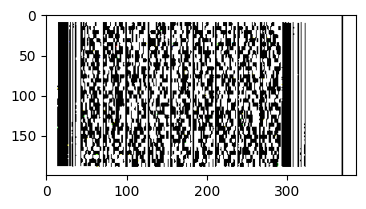

In [ ]:
in_bar = PIL.Image.fromarray(filt_bcodes[0].image)
ret,in_bar = cv2.threshold(np.array(in_bar),127,255,cv2.THRESH_BINARY)

display_multi(in_bar,figsize=(4,4))

In [ ]:
results = zxingcpp.read_barcodes(img)
for result in results:
    print("Found barcode:\n Text:    '{}'\n Format:   {}\n Position: {}"
        .format(result.text, result.format, result.position))

if len(results) == 0:
    print("Could not find any barcode.")


Found barcode:
 Text:    '<barcode app="EPMS" version="1.0" id="1" count="1" origsys="NASS" origsyskey="MSC2191127442" schedKey="" acceptdate="" ><table name="applicant">a2255 GLADES ROAD STE 324A,bBOCA RATON,cFL,d33431,eI485,fNBC,gJANNATUL,hRAFIA-TRACY,p825125000,qA219860367,r19880626,CXBH1S1,I75e0a78c-7d6c-4076-ac1d-4d747418eed2,K3,LMSC2191127445,MI765,</table></barcode>'
 Format:   BarcodeFormat.PDF417
 Position: 1045x429 1488x430 1487x685 1045x685 
Found barcode:
 Text:    'MSC2191127445'
 Format:   BarcodeFormat.Code39
 Position: 1034x1852 1357x1852 1357x1940 1033x1940 
Found barcode:
 Text:    'MSC2191127442'
 Format:   BarcodeFormat.Code39
 Position: 324x1899 648x1899 648x1944 324x1944 


In [ ]:
result.text.split('name')[-1].split(',')

['MSC2191127442']

In [ ]:
# all_documents = glob("/content/documents/forms/*")
all_documents = glob("/content/documents/AI Receipts Project/*")

print('Total Documents:',len(all_documents))
print(all_documents)

pdf_path = '/content/documents/AI Receipts Project/A-1.pdf' #all_documents[1]
pdf_name,_ = os.path.splitext(pdf_path.split('/')[-1])
print(pdf_path,pdf_name)
print('Size(Mb):',round(os.path.getsize(pdf_path)/1024/1024))

## convert pdf to images
all_pages = convert_from_path(pdf_path)
print('Total Pages:',len(all_pages))


Total Documents: 40
['/content/documents/AI Receipts Project/V-2.pdf', '/content/documents/AI Receipts Project/B-2.pdf', '/content/documents/AI Receipts Project/R-1.pdf', '/content/documents/AI Receipts Project/P-1.pdf', '/content/documents/AI Receipts Project/A-2.pdf', '/content/documents/AI Receipts Project/H-1.pdf', '/content/documents/AI Receipts Project/N-1.pdf', '/content/documents/AI Receipts Project/V-1.pdf', '/content/documents/AI Receipts Project/Q-1.pdf', '/content/documents/AI Receipts Project/L-2.pdf', '/content/documents/AI Receipts Project/C-1.pdf', '/content/documents/AI Receipts Project/M-2.pdf', '/content/documents/AI Receipts Project/W-1.pdf', '/content/documents/AI Receipts Project/K-1.pdf', '/content/documents/AI Receipts Project/I-1.pdf', '/content/documents/AI Receipts Project/Z-1.pdf', '/content/documents/AI Receipts Project/E-2.pdf', '/content/documents/AI Receipts Project/C-2.pdf', '/content/documents/AI Receipts Project/B-1.pdf', '/content/documents/AI Receip

['MICHELE', 'BRIDGES-AURIGEMMA']
MICHELE BRIDGES-AURIGEMMA


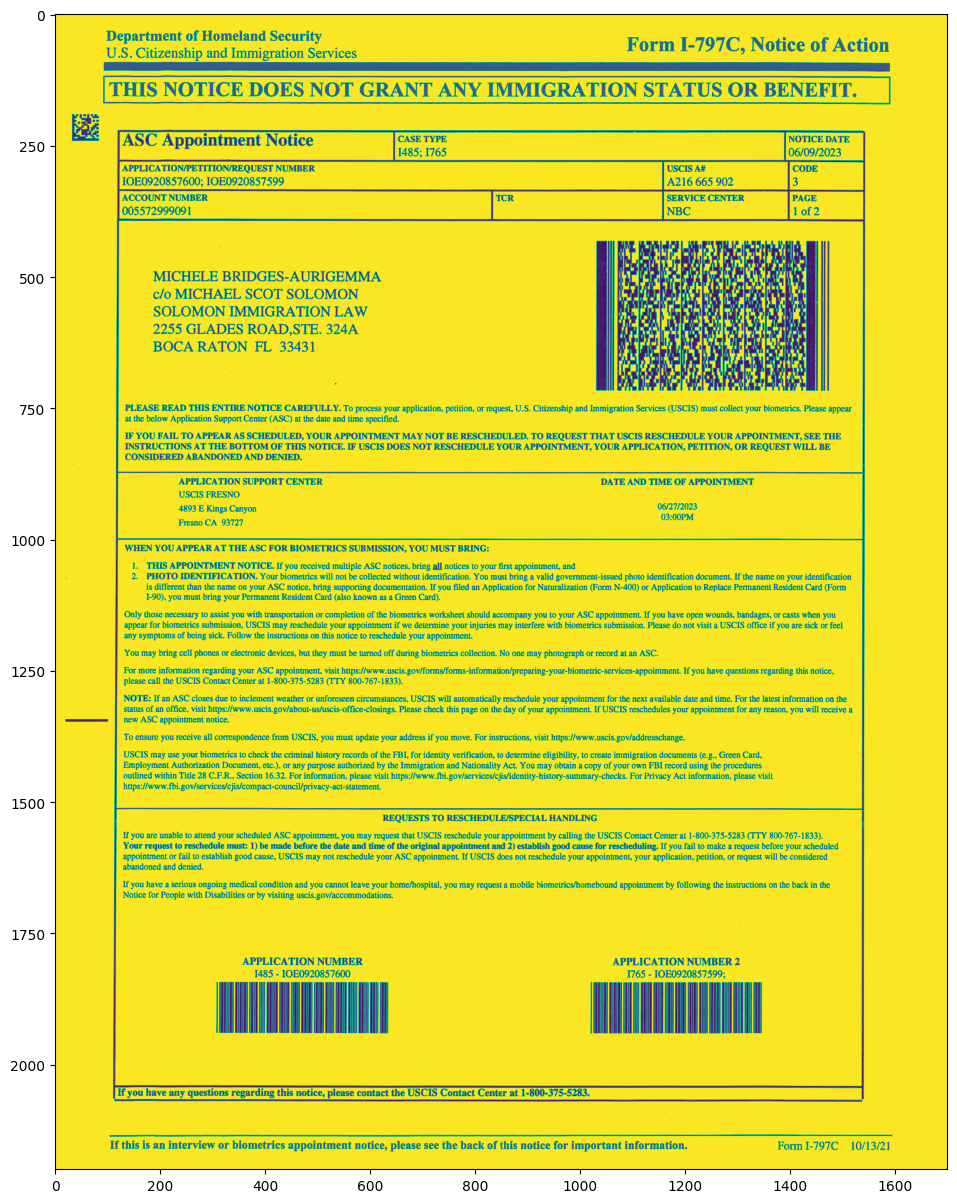

In [ ]:
# op_dpi = (300,300)
op_deskew = True
op_img_thresh = False   ## True makes I to 1 so keep it false
op_borders = (False,10,(0,0,0))

# ## thresholding and morphology
# # ['try_all_threshold','threshold_otsu','threshold_yen','threshold_isodata','threshold_li','threshold_local','threshold_minimum','threshold_mean', 'threshold_niblack','threshold_sauvola','threshold_triangle','apply_hysteresis_threshold','threshold_multiotsu']
# thresh_filter = None#skimage.filters.threshold_otsu
# op_morph = None #apply_morph(img,morph_operation=cv2.MORPH_CLOSE,kernel=(3,3),iterations=1)



# img = cv2.imread('/content/documents/131_raw/page_4.png')
img = np.array(all_pages[14])
img = cv2.cvtColor(np.array(img),cv2.COLOR_RGB2GRAY)

try:
    img = check_orientation_tesseract(np.array(img))
except:
    pass

img = preprocess_image(img,deskew=op_deskew,img_thresh=op_img_thresh,\
                        add_border=op_borders[0],border_width=op_borders[1],border_color=op_borders[2],img_type='gray')
# img_regions = detect_regions(img)
# len(img_regions)
bcode_417 = read_bcode_from_img(img)
bcode_name = get_name_from_bcode(bcode_417)
print(bcode_name)
separator=' '
bcode_name = str(separator.join(bcode_name))
print(bcode_name)
display_multi(img)



In [ ]:
print(get_name_from_bcode(bcode_417))
bcode_417.text.split('name')[-1].split(',')

In [ ]:
display_info=False
save_jpegs = False
save_images = True
save_zips = True

!rm -r '/content/drive/MyDrive/immediate/processed_name/'
path_write_all = '/content/drive/MyDrive/immediate/processed_name/'
if not os.path.isdir(path_write_all):
    os.mkdir(path_write_all)

path_write_pdfs = os.path.join(path_write_all,'pdfs/')
if not os.path.isdir(path_write_pdfs):
    os.mkdir(path_write_pdfs)

if save_jpegs==True:
    path_write_junk = os.path.join(path_write_all,'junk/')
    if not os.path.isdir(path_write_junk):
        os.mkdir(path_write_junk)

if save_images==True:
    path_write_images = os.path.join(path_write_all,'images/')
    if not os.path.isdir(path_write_images):
        os.mkdir(path_write_images)

if save_zips==True:
    path_write_zips = os.path.join(path_write_all,'zips/')
    if not os.path.isdir(path_write_zips):
        os.mkdir(path_write_zips)


st_i = None#0
num_forms = None# 1
end_i = None#5#st_i+num_forms

all_corrupts = []
for doc_index in tqdm(range(0,len(all_documents[:]))):

    pdf_path = all_documents[doc_index]
    pdf_name,_ = os.path.splitext(pdf_path.split('/')[-1])
    print(pdf_path,pdf_name)
    print('Size(Mb):',round(os.path.getsize(pdf_path)/1024/1024))

    # if os.path.isfile(os.path.join(save_zip_path,pdf_name+'.zip')):
    #     continue

    ## convert pdf to images
    all_pages = convert_from_path(pdf_path)
    print('Total Pages:',len(all_pages))

    if save_jpegs==True:
        junk_folder = os.path.join(path_write_junk,pdf_name+'_junk/')
        if not os.path.isdir(junk_folder):
            os.mkdir(junk_folder)
    else:
        junk_folder = None

    pdf_folder = os.path.join(path_write_pdfs,pdf_name+'_pdfs/')
    if not os.path.isdir(pdf_folder):
        os.mkdir(pdf_folder)

    if save_images==True:
        images_folder = os.path.join(path_write_images,pdf_name+'_images/')
        if not os.path.isdir(images_folder):
            os.mkdir(images_folder)


    for p in range(0,len(all_pages)):
        img = np.array(all_pages[p])
        img = cv2.cvtColor(np.array(img),cv2.COLOR_RGB2GRAY)

        try:
            img = check_orientation_tesseract(np.array(img))
        except:
            pass

        img = preprocess_image(img,deskew=op_deskew,img_thresh=op_img_thresh,\
                                add_border=op_borders[0],border_width=op_borders[1],border_color=op_borders[2],img_type='gray')
        # img_regions = detect_regions(img)
        # len(img_regions)
        try:
            bcode_417 = read_bcode_from_img(img)
            bcode_name = get_name_from_bcode(bcode_417)
            # separator=' '
            # bcode_name = str(separator.join(bcode_name))
        except:
            bcode_name = 'None'

        final_name = pdf_name+'_'+str(p)+'_'+str(bcode_name)+'.jpg'
        final_name = os.path.join(path_write_all,final_name)
        cv2.imwrite(final_name,img,[cv2.IMWRITE_JPEG_QUALITY, 10])

    # all_final_names,all_final_appends,corrupts = process_and_save(all_pages,junk_folder,display_info=display_info,st_i=st_i,end_i=end_i,save_jpegs=save_jpegs)
    # all_corrupts.append(all_corrupts)

    # all_files_pagewise = make_pagewise_list(all_final_names,all_final_appends)
    # break_pdf_to_files(pdf_path,pdf_folder,all_files_pagewise,compress_pdf=True)

    # if save_images==True:
    #     selected_pages = all_pages[st_i:end_i]
    #     break_pdf_to_images(selected_pages,images_folder,all_files_pagewise,jpeg_quality=10)

    # if save_zips==True:
    #     zip_name = os.path.join(path_write_zips,pdf_name+'.zip')
    #     !zip -r {zip_name} {images_folder}


rm: cannot remove '/content/processed_pdfs/': No such file or directory


  0%|          | 0/40 [00:00<?, ?it/s]

/content/documents/AI Receipts Project/V-2.pdf V-2
Size(Mb): 30
Total Pages: 20


  2%|▎         | 1/40 [01:56<1:15:51, 116.70s/it]

/content/documents/AI Receipts Project/B-2.pdf B-2
Size(Mb): 70
